In [1]:
import os
import sys
import time
import glob
import shutil
import pandas as pd
import pickle
import numpy as np
import datetime
import zipfile
import matplotlib.pyplot as plt

import math
import matlab.engine

import torch
from torch.nn import functional as F
# import torchvision
# from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim, nn
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.utils.data import Dataset
import torch.nn.init as init
from sklearn import datasets
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2
import utils as Common
import utils_2 as utils
import utils_3 as vRef
import utils_4 as ML

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

Project = '3BVT'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


# Sim with CARSIM

## Convert ZIP(D97-->CSV)

In [2]:
l_DATA = []
l_DATA.append('c:\\TSDE_Workarea\\ktt2yk\\Projects\\3BVT\\')
PLT = 'c:\\TSDE_Workarea\\ktt2yk\\Work\\Tire_Torque\\Conv_Est_Tire.PLT'

SAMPLING = 0.005 

In [3]:
l_d_CSVs = []

for DATA in l_DATA:
    PATH_Search = [DATA]
    PLT_Convert = PLT 
    d_SIGNAL_PLT = Common.Select_Signal(PLT_Convert)
    d_CSVs, l_Not_Convert = Common.SAVE_ZIP_to_CSV(d_SIGNAL_PLT, PATH_Search, SAMPLING, False)

    PKL = f'{DATA}\\CSV_List_{Project}.pkl'
    with open(PKL, 'wb') as file:
        pickle.dump(d_CSVs, file)
    
    l_d_CSVs.append(d_CSVs)

['c:\\TSDE_Workarea\\ktt2yk\\Projects\\3BVT\\']
1 / 542 ; c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC/20231026_0000.ZIP 38459660
2 / 542 ; c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC/20231026_0001.ZIP 39976918
3 / 542 ; c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC/20231026_0002.ZIP 36092184
4 / 542 ; c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC/20231026_0003.ZIP 39123192
5 / 542 ; c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC/20231026_0004.ZIP 53454679
6 / 542 ; c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC/20231026_0005.ZIP 35170874
7 / 542 ; c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC/20231026_0006.ZIP 34193249
8 / 542 ; c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC/20231026_0007.ZIP 32841315
9 / 542 ; c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC/20231026_0008.ZIP 23251784
10 / 542 ; c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC/20231026_0009.ZIP 21683761
11 / 542 ; c:\TSDE_Workarea\ktt

## Data List

In [4]:
d_CSV = {}
for d_ in l_d_CSVs:
    for ZIP in d_:
        Comment, CSV, _ = d_[ZIP]
        ZIP = ZIP.replace('\\/', '\\')
        d_CSV[CSV] = {'ZIP': ZIP, 'Comment': Comment}

DIR = 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\\'
PKL = f'{DIR}\\Data_List_{Project}_MMotAct_MDriverRequest.pkl'
with open(PKL, 'wb') as file:
    pickle.dump(d_CSV, file)

## vRef

In [53]:
d_CSV_vRef = {}

for i, CSV in enumerate(d_CSV):
    updated_CSV = CSV
    Out = vRef.vRef(CSV, updated_CSV, override=False)
    if Out != None:      
        d_CSV_vRef[CSV] = d_CSV[CSV]
        print(f'{(i+1)}/{len(d_CSV)}, {CSV}: Success')
    else:
        print(f'{(i+1)}/{len(d_CSV)}, {CSV}: Failure')

1/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0000.csv: Success
2/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0001.csv: Success
3/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0002.csv: Success
4/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0003.csv: Success
5/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0004.csv: Success
6/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0005.csv: Success
7/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0006.csv: Success
8/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0007.csv: Success
9/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0008.csv: Success
10/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0009.csv: Success
11/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0010.csv: Success
12/410, c:\TSDE_Wor

## Estimate Wheel Torque

In [54]:
DIR = 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\\'
MDL_Est = f'{DIR}Carsim_Est_2_HGT_3BVT.mdl'
matlab_version = "R2022b"

d_SIMs = ML.EstimateWheelTorque(d_CSV_vRef, '3BVT_FWD_Stdless_low_spd', DIR, MDL_Est, matlab_version, override=False)

PKL = f'{DIR}\\Sim_List_{Project}.pkl'
with open(PKL, 'wb') as file:
    pickle.dump(d_SIMs, file)

Extracted 20231026_0000_0_3BVT_FWD_Stdless_low_spd.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
1/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0000.csv: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\20231026_0000_0_3BVT_FWD_Stdless_low_spd.csv
Extracted 20231026_0001_1_3BVT_FWD_Stdless_low_spd.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
2/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0001.csv: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\20231026_0001_1_3BVT_FWD_Stdless_low_spd.csv
Extracted 20231026_0002_2_3BVT_FWD_Stdless_low_spd.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
3/410, c:\TSDE_Workarea\ktt2yk\Projects\3BVT\20231026_TCS_VDC\20231026_0002.csv: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\20231026_0002_2_3BVT_FWD_Stdless_low_spd.cs

## Selecting Data

In [55]:
# データ選別
contain_list = ['snow']
not_contain_list = ['split', 'abs', 'ice', 'hill', '10%']
ignore_list = []
d_Selected_CSVs = ML.Search_Comment(d_SIMs, contain_list, not_contain_list, ignore_list=ignore_list)
print(f'Snow: {len(d_Selected_CSVs)}')

# contain_list = ['ms']
# not_contain_list = ['summer', 'measure_v57_2wd', 'measure_v53_kh', 'measure_v75_2wd_wtsa', 'measure_v85_2wd_kyg']
# d_Selected_CSVs = ML.Search_Comment(d_Selected_CSVs, contain_list, not_contain_list)
# print(f'MS: {len(d_Selected_CSVs)}')

# 重複データの削除
d_Selected_CSVs = ML.removing_duplication_files(d_Selected_CSVs)
print(f'Duplication: {len(d_Selected_CSVs)}')

PKL = f'{DIR}\\Sim_List_{Project}.pkl'
with open(PKL, 'wb') as file:
    pickle.dump(d_Selected_CSVs, file)

Snow: 37
Duplication: 37


In [56]:
# d_Selected_CSVs

# Data for ML

## Features

In [13]:
def Create_Features_EstWhlTrq(d_Datas, abrollumfang, vibration_thresholds=None, vibration=False):
    for F in d_Datas:
        File = d_Datas[F]['Features']
        root, ext = os.path.splitext(File)
        zip_file = f'{root}.zip'
        extracted_files = Common.Unpack_ZIP_to_CSV(zip_file, remove_zip=True)
        df = pd.read_table(extracted_files[0], sep=',')

        df['diff_Vx_L1'] = df['Vx_L1'] - df['Vx_R1']
        df['diff_Vx_R1'] = df['Vx_R1'] - df['Vx_L1']
        df['diff_Vx_L2'] = df['Vx_L2'] - df['Vx_R2']
        df['diff_Vx_R2'] = df['Vx_R2'] - df['Vx_L2']
        df['dev_Vx_L1'] = df['Vx_L1'] - df['Vx']
        df['dev_Vx_R1'] = df['Vx_R1'] - df['Vx'] 
        df['dev_Vx_L2'] = df['Vx_L2'] - df['Vx']
        df['dev_Vx_R2'] = df['Vx_R2'] - df['Vx']

        df['abs_diff_Vx'] = (df['Vx'] - df['V'] * 3.6).abs()
        df['abs_diff_Vx_L1'] = (df['Vx_L1'] - df['v_FL'] * 3.6).abs()
        df['abs_diff_Vx_R1'] = (df['Vx_R1'] - df['v_FR'] * 3.6).abs()
        df['abs_diff_Vx_L2'] = (df['Vx_L2'] - df['v_RL'] * 3.6).abs()
        df['abs_diff_Vx_R2'] = (df['Vx_R2'] - df['v_RR'] * 3.6).abs()

        df['GearRatio'] = (df['nDrvUnit'] / 60 ) / (((df['Vx_L1'] + df['Vx_R1']) / 2 * df['Co_FA'] + (df['Vx_L2'] + df['Vx_R2']) / 2 * (1 - df['Co_FA'])) / 3.6 / abrollumfang)
        df['GearRatio'] = df['GearRatio'].clip(lower=0, upper=20)

        df['abs_Sas'] = df['Steer_in'].abs()
        df['abs_vGiF'] = df['vGiF'].abs()
        df['abs_ayToF'] = df['ayToF'].abs()
    
        if 'ThrottlePos' not in df.columns and 'Throttle_in' in df.columns:
            df['ThrottlePos'] = df['Throttle_in']
        
        Filtered_Sigs = [(['IMP_MY_OUT_DR_L1', 'IMP_MY_OUT_DR_R1', 'IMP_MY_OUT_DR_L2', 'IMP_MY_OUT_DR_R2'], [10, 20, 40, 100, 200, 400], True),
                         (['IMP_FX_L1', 'IMP_FX_R1', 'IMP_FX_L2', 'IMP_FX_R2'], [10, 20, 40, 100, 200, 400], False),
                         (['Fz_L1', 'Fz_R1', 'Fz_L2', 'Fz_R2'], [400], False),
                         (['Ax_SM', 'MMotAct', 'ThrottlePos', 'GearRatio'], [10, 20, 40, 100, 200, 400], False),
                         (['diff_Vx_L1', 'diff_Vx_R1', 'diff_Vx_L2', 'diff_Vx_R2'], [10, 20, 40, 100, 200, 400], False),
                         (['dev_Vx_L1', 'dev_Vx_R1', 'dev_Vx_L2', 'dev_Vx_R2'], [10, 20, 40, 100, 200, 400], False),
                         (['p_FL', 'p_FR'], [10, 20, 40, 100, 200, 400], False)]
        
        for data in Filtered_Sigs:
            Sigs, Ns, center = data
            for Sig in Sigs:
                for N in Ns:
                    df[f'{Sig}_{str(N)}'] = df[Sig].rolling(window=N, center=center).mean()

        if vibration == True:
            df = ML.detect_vibration(df, thresholds)
        
        df.to_csv(extracted_files[0], index=False)
        _ = Common.SAVE_CSV_to_ZIP(extracted_files[0], remove_csv=True)

In [14]:
def Create_Features(Datas, Filtered_Sigs):
    for file in Datas:
        df = pd.read_table(file, sep=',')

        df['v_RA_kph'] = (df['v_RL'] + df['v_RR']) / 2 * 3.6
        
        for data in Filtered_Sigs:
            Sigs, Ns = data
            for Sig in Sigs:
                for N in Ns:
                    df[f'{Sig}_{str(N)}'] = df[Sig].rolling(window=N, center=False).mean()
        
        df.to_csv(file, index=False)

In [15]:
def Create_Train_Val_Data_EstWhlTrq(d_Datas, dir, project, train=0.7, MY_OUT=False, add=''):
    data_list = list(d_Datas.keys())
    shuffled_indices = np.random.permutation(len(data_list))
    end = int(len(data_list) * train)
    train_indices = shuffled_indices[:end]
    val_indices = shuffled_indices[end:]

    train_list = []
    for i in train_indices:
        file = d_Datas[data_list[i]]['Features']
        train_list.append(file)

    if len(train_list) != 0:
        df = Create_Data_EstWhlTrq(train_list, MY_OUT)
        train_file = f'{dir}train_data_{project}_EstWhlTrq{add}.pkl'
        with open(train_file, 'wb') as file:
            pickle.dump(df, file)
    else:
        train_file = None
            
    val_list = []
    for i in val_indices:
        file = d_Datas[data_list[i]]['Features']
        val_list.append(file)

    if len(val_list) != 0:
        df = Create_Data_EstWhlTrq(val_list, MY_OUT)
        val_file = f'{dir}val_data_{project}_EstWhlTrq{add}.pkl'
        with open(val_file, 'wb') as file:
            pickle.dump(df, file)
    else:
        val_file = None

    return train_file, val_file, train_list, val_list

In [16]:
def Create_Train_Val_Data(Datas, dir, project, add_name=None, train=0.7):
    data_list = list(Datas.keys())
    shuffled_indices = np.random.permutation(len(data_list))
    end = int(len(data_list) * train)
    train_indices = shuffled_indices[:end]
    val_indices = shuffled_indices[end:]

    train_list = []
    for i in train_indices:
        file = data_list[i]
        train_list.append(file)

    if add_name == None:
        add = ''
    else:
        add = f'_{add_name}'
    
    df = Create_Data(train_list)
    train_file = f'{dir}train_data_{project}{add}.pkl'
    with open(train_file, 'wb') as file:
        pickle.dump(df, file)
        
    val_list = []
    for i in val_indices:
        file = data_list[i]
        val_list.append(file)

    df = Create_Data(val_list)

    val_file = f'{dir}val_data_{project}{add}.pkl'
    with open(val_file, 'wb') as file:
        pickle.dump(df, file)

    return train_file, val_file, train_list, val_list

In [17]:
def Create_Data_EstWhlTrq(data_list, MY_OUT):    
    for i, File in enumerate(data_list):    
        root, ext = os.path.splitext(File)
        zip_file = f'{root}.zip'
        extracted_files = Common.Unpack_ZIP_to_CSV(zip_file, remove_zip=False)
        df = pd.read_table(File, sep=',')
        
        if i == 0:
            df_concat = df
        else:
            df_concat = pd.concat([df_concat, df], axis=0, ignore_index=True)
    
        for file in extracted_files:
            if os.path.exists(file):
                os.remove(file)

    if MY_OUT == True:
        # print(File)
        change_sigs = {}
        change_sigs['IMP_FX_x1_10'] = ['IMP_FX_L1_10', 'IMP_FX_R1_10']
        change_sigs['IMP_FX_x1_20'] = ['IMP_FX_L1_20', 'IMP_FX_R1_20']
        change_sigs['IMP_FX_x1_40'] = ['IMP_FX_L1_40', 'IMP_FX_R1_40']
        change_sigs['IMP_FX_x1_100'] = ['IMP_FX_L1_100', 'IMP_FX_R1_100']
        change_sigs['IMP_FX_x1_200'] = ['IMP_FX_L1_200', 'IMP_FX_R1_200']
        change_sigs['IMP_FX_x1_400'] = ['IMP_FX_L1_400', 'IMP_FX_R1_400']
        # change_sigs['IMP_FX_x2'] = ['IMP_FX_L2_40', 'IMP_FX_R2_40']
        change_sigs['Fz_x1'] = ['Fz_L1_400', 'Fz_R1_400']
        change_sigs['Fz_x2'] = ['Fz_L2_400', 'Fz_R2_400']
        change_sigs['diff_Vx_x1_10'] = ['diff_Vx_L1_10', 'diff_Vx_R1_10']
        change_sigs['diff_Vx_x1_20'] = ['diff_Vx_L1_20', 'diff_Vx_R1_20']
        change_sigs['diff_Vx_x1_40'] = ['diff_Vx_L1_40', 'diff_Vx_R1_40']
        change_sigs['diff_Vx_x1_100'] = ['diff_Vx_L1_100', 'diff_Vx_R1_100']
        change_sigs['diff_Vx_x1_200'] = ['diff_Vx_L1_200', 'diff_Vx_R1_200']
        change_sigs['diff_Vx_x1_400'] = ['diff_Vx_L1_400', 'diff_Vx_R1_400']
        change_sigs['dev_Vx_x1_10'] = ['dev_Vx_L1_10', 'dev_Vx_R1_10']
        change_sigs['dev_Vx_x1_20'] = ['dev_Vx_L1_20', 'dev_Vx_R1_20']
        change_sigs['dev_Vx_x1_40'] = ['dev_Vx_L1_40', 'dev_Vx_R1_40']
        change_sigs['dev_Vx_x1_100'] = ['dev_Vx_L1_100', 'dev_Vx_R1_100']
        change_sigs['dev_Vx_x1_200'] = ['dev_Vx_L1_200', 'dev_Vx_R1_200']
        change_sigs['dev_Vx_x1_400'] = ['dev_Vx_L1_400', 'dev_Vx_R1_400']
        change_sigs['diff_Vx_x2_10'] = ['diff_Vx_L2_10', 'diff_Vx_R2_10']
        change_sigs['diff_Vx_x2_20'] = ['diff_Vx_L2_20', 'diff_Vx_R2_20']
        change_sigs['diff_Vx_x2_40'] = ['diff_Vx_L2_40', 'diff_Vx_R2_40']
        change_sigs['diff_Vx_x2_100'] = ['diff_Vx_L2_100', 'diff_Vx_R2_100']
        change_sigs['diff_Vx_x2_200'] = ['diff_Vx_L2_200', 'diff_Vx_R2_200']
        change_sigs['diff_Vx_x2_400'] = ['diff_Vx_L2_400', 'diff_Vx_R2_400']
        change_sigs['dev_Vx_x2_10'] = ['dev_Vx_L2_10', 'dev_Vx_R2_10']
        change_sigs['dev_Vx_x2_20'] = ['dev_Vx_L2_20', 'dev_Vx_R2_20']
        change_sigs['dev_Vx_x2_40'] = ['dev_Vx_L2_40', 'dev_Vx_R2_40']
        change_sigs['dev_Vx_x2_100'] = ['dev_Vx_L2_100', 'dev_Vx_R2_100']
        change_sigs['dev_Vx_x2_200'] = ['dev_Vx_L2_200', 'dev_Vx_R2_200']
        change_sigs['dev_Vx_x2_400'] = ['dev_Vx_L2_400', 'dev_Vx_R2_400']
        change_sigs['p_Fx_10'] = ['p_FL_10', 'p_FR_10']
        change_sigs['p_Fx_20'] = ['p_FL_20', 'p_FR_20']
        change_sigs['p_Fx_40'] = ['p_FL_40', 'p_FR_40']
        change_sigs['p_Fx_100'] = ['p_FL_100', 'p_FR_100']
        change_sigs['p_Fx_200'] = ['p_FL_200', 'p_FR_200']
        change_sigs['p_Fx_400'] = ['p_FL_400', 'p_FR_400']
        change_sigs['p_Fx_2_10'] = ['p_FR_10', 'p_FL_10']
        change_sigs['p_Fx_2_20'] = ['p_FR_20', 'p_FL_20']
        change_sigs['p_Fx_2_40'] = ['p_FR_40', 'p_FL_40']
        change_sigs['p_Fx_2_100'] = ['p_FR_100', 'p_FL_100']
        change_sigs['p_Fx_2_200'] = ['p_FR_200', 'p_FL_200']
        change_sigs['p_Fx_2_400'] = ['p_FR_400', 'p_FL_400']
        change_sigs['IMP_MY_OUT_DR_x1'] = ['IMP_MY_OUT_DR_L1_40', 'IMP_MY_OUT_DR_R1_40']
        change_sigs['IMP_MY_OUT_DR_x2'] = ['IMP_MY_OUT_DR_L2_40', 'IMP_MY_OUT_DR_R2_40']
        
        for i in [0, 1]:
            for sig in change_sigs:
                # print(df_concat.columns)
                # print(change_sigs[sig][i])
                df_concat[sig] = df_concat[change_sigs[sig][i]]
            if i == 0:
                df_out = df_concat
            else:
                df_out = pd.concat([df_out, df_concat], axis=0, ignore_index=True)
        
        # df_out.to_csv(out, index=False)

    else:
        df_out = df_concat
    return df_out

In [18]:
def Create_Data(data_list):    
    for i, file in enumerate(data_list):    
        df = pd.read_table(file, sep=',')
        
        if i == 0:
            df_concat = df
        else:
            df_concat = pd.concat([df_concat, df], axis=0, ignore_index=True)

    return df_concat

## Run

### Estimating Wheel Torque(MY_OUT)

In [27]:
# pickleファイルを読み込む
DIR = 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\\'
file_path = f'{DIR}Sim_List_{Project}.pkl'
with open(file_path, 'rb') as file:
    d_SIMs = pickle.load(file)

In [28]:
# サンプリング時間の変更
d_SIMs = ML.Resampling(d_SIMs, override=False)
print(len(d_SIMs))

37


In [29]:
# Adding signals
# PLT = 'c:\\TSDE_Workarea\\ktt2yk\\Work\\Tire_Torque\\Conv_Est_Tire.PLT'
# Add_Signals = ['MDriverRequest']
# d_SIMs = ML.Adding_Signals(d_SIMs, Add_Signals, PLT)

In [30]:
# データ選別
# contain_list = []
# not_contain_list = ['2024_0x1_TakasuWinter_for_Sim']
# ignore_list = []
# d_SIMs_Train = ML.Search_Comment(d_SIMs, contain_list, not_contain_list, ignore_list=ignore_list)
# print(f'Train: {len(d_SIMs_Train)}/{len(d_SIMs)}')

# contain_list = ['2024_0x1_TakasuWinter_for_Sim']
# not_contain_list = []
# ignore_list = []
# d_SIMs_Val = ML.Search_Comment(d_SIMs, contain_list, not_contain_list, ignore_list=ignore_list)
# print(f'Val: {len(d_SIMs_Val)}/{len(d_SIMs)}')

contain_list = []
not_contain_list = ['20240208_0051_361', '20240208_0048_358', '20240208_0047_357', '20240208_0023_333', '20240208_0020_375', '20240208_0016_326', '20240208_0013_368', '20240208_0012_322', '20240208_0011_366', '20240208_0009_319', '20240208_0000_310', '20240206_0032_260', '20240206_0012_240']
ignore_list = []
d_SIMs = ML.Search_Comment(d_SIMs, contain_list, not_contain_list, ignore_list=ignore_list)
print(f'Train: {len(d_SIMs)}/{len(d_SIMs)}')

Train: 24/24


In [31]:
# 特徴量の作成
# Train_Data, _, Train_list, _ = Create_Train_Val_Data_EstWhlTrq(d_SIMs_Train, DIR, train=1.0)
# _, Val_Data, _, Val_list = Create_Train_Val_Data_EstWhlTrq(d_SIMs_Val, DIR, train=0.0)
Train_Data, Val_Data, Train_list, Val_list = Create_Train_Val_Data_EstWhlTrq(d_SIMs, DIR, Project, train=0.7, MY_OUT=True)
print(f'Train: {Train_Data}')
print(f'Validation: {Val_Data}')

# PKL = f'{Dir}\\Train_Val_Datas.pkl'
# with open(PKL, 'wb') as file:
#     pickle.dump((Train_Data, Val_Data, Train_list, Val_list), file)

Extracted 20240213_0006_389_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240208_0026_336_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240213_0013_396_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240213_0025_408_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240213_0001_384_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240208_0014_369_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240213_0008_391_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240213_0021_404

### Estimating Wheel Torque(FX)

In [32]:
# pickleファイルを読み込む
DIR = 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\\'
file_path = f'{DIR}Sim_List_{Project}.pkl'
with open(file_path, 'rb') as file:
    d_SIMs = pickle.load(file)

In [33]:
# サンプリング時間の変更
d_SIMs = ML.Resampling(d_SIMs, override=False)
print(len(d_SIMs))

37


In [34]:
# Adding signals
# PLT = 'c:\\TSDE_Workarea\\ktt2yk\\Work\\Tire_Torque\\Conv_Est_Tire.PLT'
# Add_Signals = ['MDriverRequest']
# d_SIMs = ML.Adding_Signals(d_SIMs, Add_Signals, PLT)

In [35]:
# データ選別
# contain_list = []
# not_contain_list = ['2024_0x1_TakasuWinter_for_Sim', '20240208_0051_361', '20240208_0048_358', '20240208_0047_357', '20240208_0023_333', '20240208_0020_375', '20240208_0016_326', '20240208_0013_368', '20240208_0012_322', '20240208_0011_366', '20240208_0009_319', '20240208_0000_310', '20240206_0032_260', '20240206_0012_240']
# ignore_list = []
# d_SIMs_Train = ML.Search_Comment(d_SIMs, contain_list, not_contain_list, ignore_list=ignore_list)
# print(f'Train: {len(d_SIMs_Train)}/{len(d_SIMs)}')

# contain_list = ['2024_0x1_TakasuWinter_for_Sim']
# not_contain_list = ['20240208_0051_361', '20240208_0048_358', '20240208_0047_357', '20240208_0023_333', '20240208_0020_375', '20240208_0016_326', '20240208_0013_368', '20240208_0012_322', '20240208_0011_366', '20240208_0009_319', '20240208_0000_310', '20240206_0032_260', '20240206_0012_240']
# ignore_list = []
# d_SIMs_Val = ML.Search_Comment(d_SIMs, contain_list, not_contain_list, ignore_list=ignore_list)
# print(f'Val: {len(d_SIMs_Val)}/{len(d_SIMs)}')

contain_list = []
not_contain_list = ['20240208_0051_361', '20240208_0048_358', '20240208_0047_357', '20240208_0023_333', '20240208_0020_375', '20240208_0016_326', '20240208_0013_368', '20240208_0012_322', '20240208_0011_366', '20240208_0009_319', '20240208_0000_310', '20240206_0032_260', '20240206_0012_240']
ignore_list = []
d_SIMs = ML.Search_Comment(d_SIMs, contain_list, not_contain_list, ignore_list=ignore_list)
print(f'Train: {len(d_SIMs)}/{len(d_SIMs)}')

Train: 24/24


In [36]:
# 特徴量の作成
Train_Data, Val_Data, Train_list, Val_list = Create_Train_Val_Data_EstWhlTrq(d_SIMs, DIR, Project, train=0.7, add='_FX')
print(f'Train: {Train_Data}')
print(f'Validation: {Val_Data}')

# PKL = f'{Dir}\\Train_Val_Datas.pkl'
# with open(PKL, 'wb') as file:
#     pickle.dump((Train_Data, Val_Data, Train_list, Val_list), file)

Extracted 20240213_0026_409_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240206_0010_238_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240208_0027_337_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240213_0005_388_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240213_0010_393_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240213_0020_403_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240213_0015_398_3BVT_FWD_Stdless_low_spd_5ms.csv to c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b
Extracted 20240208_0031_341

### MMotAct, MDriverRequest

In [7]:
# pickleファイルを読み込む
DIR = 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\\'
PKL = f'{DIR}\\Data_List_{Project}_MMotAct_MDriverRequest.pkl'
with open(PKL, 'rb') as file:
    d_CSV = pickle.load(file)

In [21]:
# 特徴量の作成
Train_Data, Val_Data, Train_list, Val_list = Create_Train_Val_Data(d_CSV, DIR, Project, train=0.8)
print(f'Train: {Train_Data}')
print(f'Validation: {Val_Data}')

# PKL = f'{Dir}\\Train_Val_Datas.pkl'
# with open(PKL, 'wb') as file:
#     pickle.dump((Train_Data, Val_Data, Train_list, Val_list), file)

Train: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\train_data_3BVT.pkl
Validation: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\val_data_3BVT.pkl


# ML

In [2]:
class NN(nn.Module):
    def __init__(self, num_in):
        super().__init__()
        # self.l1 = nn.Linear(num_in, 256)
        # self.b1 = nn.BatchNorm1d(256)
        # self.l2 = nn.Linear(256, 128)
        # self.b2 = nn.BatchNorm1d(128)
        # self.l3 = nn.Linear(128, 64)
        # self.b3 = nn.BatchNorm1d(64)
        # self.l4 = nn.Linear(64, 32)
        # self.b4 = nn.BatchNorm1d(32)
        # self.l5 = nn.Linear(32, 1)
        self.l1 = nn.Linear(num_in, 64)
        self.b1 = nn.BatchNorm1d(64)
        self.l2 = nn.Linear(64, 32)
        self.b2 = nn.BatchNorm1d(32)
        self.l3 = nn.Linear(32, 16)
        self.b3 = nn.BatchNorm1d(16)
        self.l4 = nn.Linear(16, 8)
        self.b4 = nn.BatchNorm1d(8)
        self.l5 = nn.Linear(8, 4) 
        self.b5 = nn.BatchNorm1d(4)
        self.l6 = nn.Linear(4, 1) 
        # パラメータの初期化
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.b1(self.l1(x)))
        x = torch.relu(self.b2(self.l2(x)))
        x = torch.relu(self.b3(self.l3(x)))
        x = torch.relu(self.b4(self.l4(x)))
        x = torch.relu(self.b5(self.l5(x)))
        x = self.l6(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

In [3]:
def transfer_learning(model, load_path):
    # load_path = 'MDriverRequest.pth'
    loaded_model = torch.load(load_path)
    model.load_state_dict(loaded_model['model_state_dict'])

    elements = ['l3', 'd3', 'l4', 'd4', 'l5', 'd5', 'l6']
    
    for name, param in model.named_parameters():
        grad = False
        for e in elements:
            if name.startswith(e):
                grad = True
                break
        if grad == False:
            param.requires_grad = False

    return model

In [4]:
def Treatment_Data_IMP_MY_OUT_DR_x1(df, selected_columns, target):
    df = df[(df['TIME'] > 10) & (df['ThrottlePos'] > 0) & (df['V_TCS'] != 10000)]

    df = df[(df['abs_diff_Vx'] < 1.0) & (df['abs_diff_Vx_L1'] < 1.0) & (df['abs_diff_Vx_R1'] < 1.0)
            & (df['abs_diff_Vx_L2'] < 1.0) & (df['abs_diff_Vx_R2'] < 1.0)]
    
    # df = df[(df['diff_Vx_L1_10'] < 1.0) & (df['diff_Vx_R1_10'] < 1.0) 
    #         & (df['diff_Vx_L2_10'] < 1.0) & (df['diff_Vx_R2_10'] < 1.0)]

    df = df[(df['abs_Sas'] < 0.5) & (df['abs_vGiF'] < 0.5) & (df['abs_ayToF'] < 0.5)]

    df = df[(df['GearRatio_10'] < 20) & (df['Ax_SM_40'] > 0.01)]
    
    condition = (df['ThrottlePos'] > 90) & (df['dev_Vx_x1_10'] < 0) & (df['dev_Vx_x1_20'] < 0) & (df['dev_Vx_x1_40'] < 0)
    df = df[~condition]
   
    df = df[selected_columns]
    df = df.dropna()
    X = df.drop(columns=[target])
    y = df[target]
    
    return X, y, df

In [5]:
def Treatment_Data_IMP_FX(df, selected_columns, target):
    df = df[(df['TIME'] > 10) & (df['ThrottlePos'] > 0) & (df['V_TCS'] != 10000)]

    df = df[(df['abs_diff_Vx'] < 1.0) & (df['abs_diff_Vx_L1'] < 1.0) & (df['abs_diff_Vx_R1'] < 1.0)
            & (df['abs_diff_Vx_L2'] < 1.0) & (df['abs_diff_Vx_R2'] < 1.0)]
    
    # df = df[(df['diff_Vx_L1_10'] < 1.0) & (df['diff_Vx_R1_10'] < 1.0) 
    #         & (df['diff_Vx_L2_10'] < 1.0) & (df['diff_Vx_R2_10'] < 1.0)]

    df = df[(df['abs_Sas'] < 0.5) & (df['abs_vGiF'] < 0.5) & (df['abs_ayToF'] < 0.5)]

    df = df[(df['GearRatio_10'] < 20) & (df['Ax_SM_40'] > 0.01)]
    
    condition = (df['ThrottlePos'] > 90) & (df['dev_Vx_L1_10'] < 0) & (df['dev_Vx_R1_10'] < 0)
    df = df[~condition]
   
    df = df[selected_columns]
    df = df.dropna()
    X = df.drop(columns=[target])
    y = df[target]
    
    return X, y, df

In [6]:
def Treatment_Data_MMotAct(df, selected_columns, target):
    # df = df[(df['TIME'] > 10) & (df['MotPedalPosDriver'] > 0)]
    df = df[df['MotPedalPosDriver'] > 0]
   
    df = df[selected_columns]
    df = df.dropna()
    X = df.drop(columns=[target])
    y = df[target]
    
    return X, y, df

### IMP_MY_OUT_DR

In [7]:
# データ準備
Dir = 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\\'
train_data = f'{Dir}train_data_{Project}_EstWhlTrq.pkl'
val_data = f'{Dir}val_data_{Project}_EstWhlTrq.pkl'

Features = ['Vx', 
            # 'Ax_SM_10', 'Ax_SM_20', 'Ax_SM_40', 'Ax_SM_100', 'Ax_SM_200', 'Ax_SM_400', 
            'Ax_SM_100', 'Ax_SM_200', 'Ax_SM_400', 
            'diff_Vx_x1_10', 'diff_Vx_x1_20', 'diff_Vx_x1_40', 'diff_Vx_x1_100', 'diff_Vx_x1_200', 'diff_Vx_x1_400',
            'dev_Vx_x1_10', 'dev_Vx_x1_20', 'dev_Vx_x1_40', 'dev_Vx_x1_100', 'dev_Vx_x1_200', 'dev_Vx_x1_400',
            'p_Fx_10', 'p_Fx_20', 'p_Fx_40', 'p_Fx_100', 'p_Fx_200', 'p_Fx_400',
            'p_Fx_2_10', 'p_Fx_2_20', 'p_Fx_2_40', 'p_Fx_2_100', 'p_Fx_2_200', 'p_Fx_2_400',
            # 'GearRatio_10', 'GearRatio_20', 'GearRatio_40', 'GearRatio_100', 'GearRatio_200', 'GearRatio_400',
            'MMotAct', 'MMotAct_10', 'MMotAct_20', 'MMotAct_40', 'MMotAct_100', 'MMotAct_200', 'MMotAct_400',
            'ThrottlePos', 'ThrottlePos_10', 'ThrottlePos_20', 'ThrottlePos_40', 'ThrottlePos_100', 'ThrottlePos_200', 'ThrottlePos_400', 
            'IMP_FX_x1_100', 'IMP_FX_x1_200', 'IMP_FX_x1_400',
            'Fz_x1', 'IMP_MY_OUT_DR_x1']
    
Target = 'IMP_MY_OUT_DR_x1'

print(f'Read: {train_data}')
with open(train_data, 'rb') as file:
    df = pickle.load(file)
X, y, df = Treatment_Data_IMP_MY_OUT_DR_x1(df, Features, Target)
df.to_csv(f'train_{Project}_{Target}.csv', index=False)

print(f'Read: {val_data}')
with open(val_data, 'rb') as file:
    df = pickle.load(file)
X_val, y_val, df = Treatment_Data_IMP_MY_OUT_DR_x1(df, Features, Target)
df.to_csv(f'val_{Project}_{Target}.csv', index=False)

Read: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\train_data_3BVT_EstWhlTrq.pkl
Read: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\val_data_3BVT_EstWhlTrq.pkl


In [8]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = X, X_val, y, y_val

# Numpy配列をTensorに変換
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# データの平均と標準偏差を計算
mean = X_train.mean(dim=0)
std = X_train.std(dim=0)

# Normalize変換を定義
transform = ML.CustomNormalize(mean, std)

train_dataset = ML.MyDataset(X_train, y_train, transform)
val_dataset = ML.MyDataset(X_val, y_val, transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=0)

In [10]:
# モデル準備
X, y = next(iter(train_loader))
num_in = X.shape[1]
model = NN(num_in)
model = model.to(device)
model = transfer_learning(model, 'IMP_MY_OUT_DR_x1_3A0A_model.pth')

FileNotFoundError: [Errno 2] No such file or directory: 'IMP_MY_OUT_DR_x1_3A0A_model.pth'

In [ ]:
# 学習率の最適値
lrs, losses = utils.lr_finder(model, train_loader, nn.MSELoss(), lr_multiplier=1.2)

In [ ]:
fig = plt.figure(figsize=(8, 3), dpi=100)
plt.plot(lrs, losses, label='losses')
plt.xscale('log')
plt.legend()
plt.ylim(0, 1000000)
plt.show()

epoch: 0: train error: 12380.30543854277, validation error: 3985.372455596924, validation accuracy: 0.08333333333333333


epoch: 1: train error: 3068.5890078787074, validation error: 3504.402088165283, validation accuracy: 0.08333333333333333


epoch: 2: train error: 2622.257318011785, validation error: 3262.454750061035, validation accuracy: 0.08333333333333333


epoch: 3: train error: 2453.2215886520125, validation error: 3210.1041634877524, validation accuracy: 0.08333333333333333


epoch: 4: train error: 2380.5161774198887, validation error: 3117.0029805501304, validation accuracy: 0.08333333333333333


epoch: 5: train error: 2333.9459404379636, validation error: 3063.2083683013916, validation accuracy: 0.08333333333333333


epoch: 6: train error: 2300.31052204714, validation error: 3070.6897983551025, validation accuracy: 0.08333333333333333


epoch: 7: train error: 2275.675584696107, validation error: 3032.0996284484863, validation accuracy: 0.08333333333333333


epoch: 8: train error: 2265.289376986229, validation error: 3046.837074915568, validation accuracy: 0.08333333333333333


epoch: 9: train error: 2262.417664608713, validation error: 3019.7313067118325, validation accuracy: 0.08333333333333333


epoch: 10: train error: 2262.086377160024, validation error: 3005.257527669271, validation accuracy: 0.08333333333333333


epoch: 11: train error: 2256.123054116459, validation error: 3037.9637254079184, validation accuracy: 0.08333333333333333


epoch: 12: train error: 2255.402658236229, validation error: 2996.5420373280845, validation accuracy: 0.08333333333333333


epoch: 13: train error: 2243.7706712625795, validation error: 2970.3090642293296, validation accuracy: 0.08333333333333333


epoch: 14: train error: 2233.3001646914727, validation error: 2962.930883407593, validation accuracy: 0.08333333333333333


epoch: 15: train error: 2206.9050975734904, validation error: 2919.0080744425454, validation accuracy: 0.08333333333333333


epoch: 16: train error: 2171.331595727953, validation error: 2875.3337020874023, validation accuracy: 0.08333333333333333


epoch: 17: train error: 2124.778175483316, validation error: 2802.5810527801514, validation accuracy: 0.08333333333333333


epoch: 18: train error: 2086.180233712924, validation error: 2786.7114804585776, validation accuracy: 0.08333333333333333


epoch: 19: train error: 2039.483749131025, validation error: 2712.118406931559, validation accuracy: 0.08333333333333333


epoch: 20: train error: 1999.1936655852753, validation error: 2650.9602406819663, validation accuracy: 0.08333333333333333


epoch: 21: train error: 1960.76441050384, validation error: 2639.975870768229, validation accuracy: 0.08333333333333333


epoch: 22: train error: 1932.2808320643537, validation error: 2575.3122227986655, validation accuracy: 0.08333333333333333


epoch: 23: train error: 1901.2637060133077, validation error: 2590.295689264933, validation accuracy: 0.08333333333333333


epoch: 24: train error: 1878.6595624503443, validation error: 2529.057421684265, validation accuracy: 0.08333333333333333


epoch: 25: train error: 1865.4156307931673, validation error: 2520.8750089009604, validation accuracy: 0.08333333333333333


epoch: 26: train error: 1852.4318299374338, validation error: 2518.8240283330283, validation accuracy: 0.08333333333333333


epoch: 27: train error: 1839.241312317929, validation error: 2485.850327809652, validation accuracy: 0.08333333333333333


epoch: 28: train error: 1844.6609703969148, validation error: 2504.634734471639, validation accuracy: 0.08333333333333333


epoch: 29: train error: 1834.8208949202199, validation error: 2495.891180038452, validation accuracy: 0.08333333333333333


epoch: 30: train error: 1833.7176834365068, validation error: 2495.7634773254395, validation accuracy: 0.08333333333333333


epoch: 31: train error: 1834.525265451205, validation error: 2489.931138356527, validation accuracy: 0.08333333333333333


epoch: 32: train error: 1834.4138007729741, validation error: 2493.3140506744385, validation accuracy: 0.08333333333333333


epoch: 33: train error: 1831.9128821421477, validation error: 2494.9960622787476, validation accuracy: 0.08333333333333333


epoch: 34: train error: 1819.7490120580642, validation error: 2491.6094512939453, validation accuracy: 0.08333333333333333


epoch: 35: train error: 1805.1844358282574, validation error: 2465.961867014567, validation accuracy: 0.08333333333333333


epoch: 36: train error: 1791.5896171957759, validation error: 2407.118410428365, validation accuracy: 0.08333333333333333


epoch: 37: train error: 1774.0787219031383, validation error: 2416.8944396972656, validation accuracy: 0.08333333333333333


epoch: 38: train error: 1749.8758162159031, validation error: 2382.1103191375732, validation accuracy: 0.08333333333333333


epoch: 39: train error: 1727.8536387298066, validation error: 2361.2336603800454, validation accuracy: 0.08333333333333333


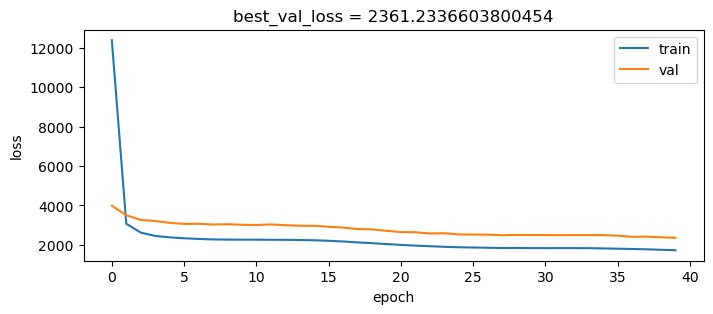

In [42]:
# 学習
model = NN(num_in)
model = model.to(device)
model = transfer_learning(model, 'IMP_MY_OUT_DR_x1_3A0A_model.pth')

num_epoch = 40
early_stopping = None
save_path = f'IMP_MY_OUT_DR_x1_{Project}_model.pth'

opt = optim.SGD(model.parameters(), lr=10**-4)
scheduler = CosineAnnealingLR(opt, T_max=10)
# opt = optim.Adam(model.parameters(), lr=10**-5, betas=(0.9, 0.999))
# scheduler=None
# scheduler = StepLR(opt, step_size=30, gamma=0.1)


train_losses, val_losses, val_accuracies, best_val_loss = utils.learn(model, train_loader, val_loader, opt, nn.MSELoss(), num_epoch=num_epoch, early_stopping=early_stopping, save_path=save_path, scheduler=scheduler)

fig = plt.figure(figsize=(8, 3), dpi=100)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'best_val_loss = {best_val_loss}')
# plt.ylim(0, 1000000)
plt.show()

epoch: 0: train error: 1716.4605578406383, validation error: 2351.2466259002686, validation accuracy: 0.08333333333333333


epoch: 1: train error: 1715.0489677817134, validation error: 2343.1716690063477, validation accuracy: 0.08333333333333333


epoch: 2: train error: 1718.615019200212, validation error: 2330.55552927653, validation accuracy: 0.08333333333333333


epoch: 3: train error: 1718.2426581948491, validation error: 2352.6368821461997, validation accuracy: 0.08333333333333333


epoch: 4: train error: 1721.3506955938824, validation error: 2347.5813020070395, validation accuracy: 0.08333333333333333


epoch: 5: train error: 1720.5961831302966, validation error: 2339.233664830526, validation accuracy: 0.08333333333333333


epoch: 6: train error: 1716.153933767545, validation error: 2343.9407316843667, validation accuracy: 0.08333333333333333


epoch: 7: train error: 1714.0537192134534, validation error: 2340.5359309514365, validation accuracy: 0.08333333333333333
Stopping early


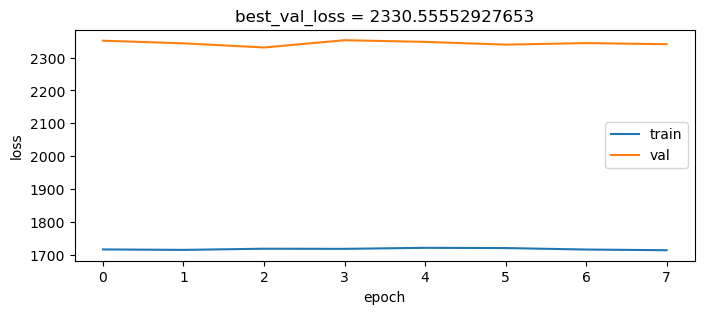

In [43]:
# 再学習
# model = NN(num_in)
# model = model.to(device)

# loaded_model = torch.load(save_path)
# model.load_state_dict(loaded_model['model_state_dict'])
model = transfer_learning(model, save_path)

num_epoch = 100
early_stopping = 5

opt = optim.Adam(model.parameters(), lr=10**-5, betas=(0.9, 0.999))
scheduler=None
# opt = optim.SGD(model.parameters(), lr=0.0001)
# scheduler = CosineAnnealingLR(opt, T_max=20)
# scheduler = StepLR(opt, step_size=30, gamma=0.1)

train_losses, val_losses, val_accuracies, best_val_loss = utils.learn(model, train_loader, val_loader, opt, nn.MSELoss(), num_epoch=num_epoch, early_stopping=early_stopping, save_path=save_path, scheduler=scheduler, best_val_loss=best_val_loss)

fig = plt.figure(figsize=(8, 3), dpi=100)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'best_val_loss = {best_val_loss}')
# plt.ylim(0, 1000000)
plt.show()

In [44]:
# 検証データの予測

# データ準備
print(f'Read: {val_data}')
with open(val_data, 'rb') as file:
    df = pickle.load(file)
X_val, y_val, _ = Treatment_Data_IMP_MY_OUT_DR_x1(df, Features, Target)

# Numpy配列をTensorに変換
X = torch.tensor(X_val.values, dtype=torch.float32)
y = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X = transform(X)

model = NN(num_in)
loaded_model = torch.load(save_path)
model.load_state_dict(loaded_model['model_state_dict'])

y_pred = model(X)

# MSEの計算
# loss = mean_squared_error(y_val.detach().numpy(), y_pred.detach().numpy())
mse = nn.MSELoss()
loss = mse(y, y_pred)
print(f'MSE Loss: {loss}')

X_val[f'{Target}'] = y.detach().numpy()
X_val[f'{Target}_pred'] = y_pred.detach().numpy()
X_val['TIME'] = np.arange(0, len(X_val)*0.005, 0.005)
columns = ['TIME'] + list(X_val.columns)
X_val = X_val[columns]
X_val.to_csv(f'{Target}_{Project}_pred.csv', index=False)

Read: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\val_data_3BVT_EstWhlTrq.pkl
MSE Loss: 2511.873046875


### IMP_FX

In [7]:
# データ準備
Dir = 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\\'
train_data = f'{Dir}train_data_{Project}_EstWhlTrq_FX.pkl'
val_data = f'{Dir}val_data_{Project}_EstWhlTrq_FX.pkl'

Features = ['Vx', 
            # 'Ax_SM_10', 'Ax_SM_20', 'Ax_SM_40', 'Ax_SM_100', 'Ax_SM_200', 'Ax_SM_400', 
            'Ax_SM_100', 'Ax_SM_200', 'Ax_SM_400', 
            'dev_Vx_L1_10', 'dev_Vx_L1_20', 'dev_Vx_L1_40', 'dev_Vx_L1_100', 'dev_Vx_L1_200', 'dev_Vx_L1_400',
            'dev_Vx_R1_10', 'dev_Vx_R1_20', 'dev_Vx_R1_40', 'dev_Vx_R1_100', 'dev_Vx_R1_200', 'dev_Vx_R1_400',
            'p_FL_10', 'p_FL_20', 'p_FL_40', 'p_FL_100', 'p_FL_200', 'p_FL_400',
            'p_FR_10', 'p_FR_20', 'p_FR_40', 'p_FR_100', 'p_FR_200', 'p_FR_400',
            # 'GearRatio_10', 'GearRatio_20', 'GearRatio_40', 'GearRatio_100', 'GearRatio_200', 'GearRatio_400',
            'MMotAct', 'MMotAct_10', 'MMotAct_20', 'MMotAct_40', 'MMotAct_100', 'MMotAct_200', 'MMotAct_400',
            'ThrottlePos', 'ThrottlePos_10', 'ThrottlePos_20', 'ThrottlePos_40', 'ThrottlePos_100', 'ThrottlePos_200', 'ThrottlePos_400', 
            # 'IMP_FX_x1_10', 'IMP_FX_x1_20', 'IMP_FX_x1_40', 'IMP_FX_x1_100', 'IMP_FX_x1_200', 'IMP_FX_x1_400',
            'Fz_L1', 'Fz_R1',
            'IMP_MY_OUT_DR_L1_40', 'IMP_MY_OUT_DR_R1_40',
            'IMP_FX_L1_20']
    
Target = 'IMP_FX_L1_20'

print(f'Read: {train_data}')
with open(train_data, 'rb') as file:
    df = pickle.load(file)
X, y, df = Treatment_Data_IMP_FX(df, Features, Target)
df.to_csv(f'train_{Project}_{Target}.csv', index=False)

print(f'Read: {val_data}')
with open(val_data, 'rb') as file:
    df = pickle.load(file)
X_val, y_val, df = Treatment_Data_IMP_FX(df, Features, Target)
df.to_csv(f'val_{Project}_{Target}.csv', index=False)

Read: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\train_data_3BVT_EstWhlTrq_FX.pkl
Read: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\val_data_3BVT_EstWhlTrq_FX.pkl


In [12]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = X, X_val, y, y_val

# Numpy配列をTensorに変換
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# データの平均と標準偏差を計算
mean = X_train.mean(dim=0)
std = X_train.std(dim=0)

# Normalize変換を定義
transform = ML.CustomNormalize(mean, std)

train_dataset = ML.MyDataset(X_train, y_train, transform)
val_dataset = ML.MyDataset(X_val, y_val, transform)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=0)

In [17]:
# モデル準備
X, y = next(iter(train_loader))
num_in = X.shape[1]
model = NN(num_in)
model = model.to(device)
model = transfer_learning(model, 'IMP_FX_3A0A_model.pth')

In [18]:
# 学習率の最適値
lrs, losses = utils.lr_finder(model, train_loader, nn.MSELoss(), lr_multiplier=1.2)

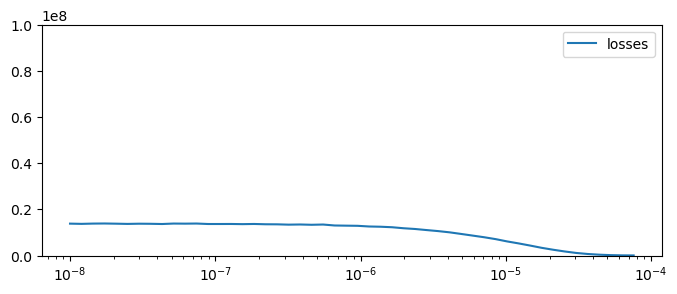

In [22]:
fig = plt.figure(figsize=(8, 3), dpi=100)
plt.plot(lrs, losses, label='losses')
plt.xscale('log')
plt.legend()
plt.ylim(0, 100000000)
plt.show()

epoch: 0: train error: 1928215.5784375, validation error: 77129.19343449519, validation accuracy: 0.0


epoch: 1: train error: 66194.65890625, validation error: 52312.101205679086, validation accuracy: 0.0


epoch: 2: train error: 49993.970703125, validation error: 43168.55288461538, validation accuracy: 0.0


epoch: 3: train error: 42992.153671875, validation error: 39676.679556039664, validation accuracy: 0.0


epoch: 4: train error: 39076.52765625, validation error: 38456.29248046875, validation accuracy: 0.0


epoch: 5: train error: 37186.4973046875, validation error: 37417.03607647236, validation accuracy: 0.0


epoch: 6: train error: 35714.4166015625, validation error: 37308.59033203125, validation accuracy: 0.0


epoch: 7: train error: 35496.4376171875, validation error: 37012.691368689906, validation accuracy: 0.0


epoch: 8: train error: 34916.2194140625, validation error: 37209.50326772837, validation accuracy: 0.0


epoch: 9: train error: 34870.0245703125, validation error: 36831.700495793266, validation accuracy: 0.0


epoch: 10: train error: 34852.914921875, validation error: 36997.971435546875, validation accuracy: 0.0


epoch: 11: train error: 34742.7168359375, validation error: 37100.82200270433, validation accuracy: 0.0


epoch: 12: train error: 34739.1885546875, validation error: 36953.44163161058, validation accuracy: 0.0


epoch: 13: train error: 34458.2686328125, validation error: 37031.85475510817, validation accuracy: 0.0


epoch: 14: train error: 34031.419375, validation error: 36548.7670710637, validation accuracy: 0.0


epoch: 15: train error: 33442.775859375, validation error: 36394.301720252406, validation accuracy: 0.0


epoch: 16: train error: 32538.5036328125, validation error: 35897.40114182692, validation accuracy: 0.0


epoch: 17: train error: 31929.4616015625, validation error: 35114.875037560094, validation accuracy: 0.0


epoch: 18: train error: 31027.2834375, validation error: 35075.13878455529, validation accuracy: 0.0


epoch: 19: train error: 30404.878359375, validation error: 34843.57692307692, validation accuracy: 0.0


epoch: 20: train error: 29862.9013671875, validation error: 33984.0927734375, validation accuracy: 0.0


epoch: 21: train error: 29383.23390625, validation error: 34024.38514122596, validation accuracy: 0.0


epoch: 22: train error: 28946.227265625, validation error: 33825.84998497596, validation accuracy: 0.0


epoch: 23: train error: 28598.20328125, validation error: 33542.05697866587, validation accuracy: 0.0


epoch: 24: train error: 28407.53859375, validation error: 33531.858924278844, validation accuracy: 0.0


epoch: 25: train error: 28257.78703125, validation error: 33102.7578125, validation accuracy: 0.0


epoch: 26: train error: 27978.37921875, validation error: 33013.50600961538, validation accuracy: 0.0


epoch: 27: train error: 27858.11515625, validation error: 33051.746056189906, validation accuracy: 0.0


epoch: 28: train error: 27907.3773046875, validation error: 33103.73599008413, validation accuracy: 0.0


epoch: 29: train error: 27814.8385546875, validation error: 33265.15951772837, validation accuracy: 0.0


epoch: 30: train error: 27826.925625, validation error: 32899.76551231971, validation accuracy: 0.0


epoch: 31: train error: 27826.6576171875, validation error: 33142.662409855766, validation accuracy: 0.0


epoch: 32: train error: 27856.5952734375, validation error: 33381.97705078125, validation accuracy: 0.0


epoch: 33: train error: 27814.4352734375, validation error: 33040.85238882212, validation accuracy: 0.0


epoch: 34: train error: 27731.12515625, validation error: 32731.68742487981, validation accuracy: 0.0


epoch: 35: train error: 27365.8373828125, validation error: 32764.008920522836, validation accuracy: 0.0


epoch: 36: train error: 27320.5921484375, validation error: 32628.29972956731, validation accuracy: 0.0


epoch: 37: train error: 27224.065078125, validation error: 32414.234600360578, validation accuracy: 0.0


epoch: 38: train error: 26774.424296875, validation error: 32258.46473106971, validation accuracy: 0.0


epoch: 39: train error: 26640.1069140625, validation error: 32143.368689903848, validation accuracy: 0.0


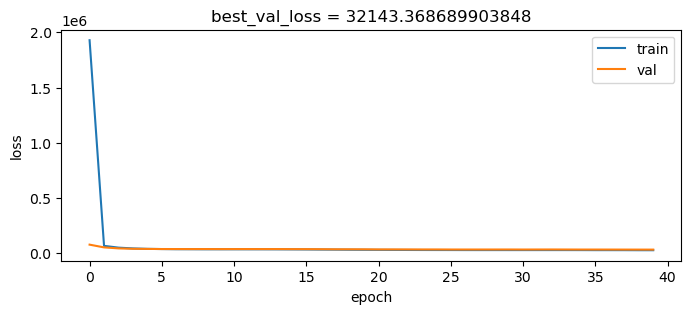

In [23]:
# 学習
model = NN(num_in)
model = model.to(device)
model = transfer_learning(model, 'IMP_FX_3A0A_model.pth')

num_epoch = 40
early_stopping = None
save_path = f'IMP_FX_{Project}_model.pth'

opt = optim.SGD(model.parameters(), lr=0.00001)
scheduler = CosineAnnealingLR(opt, T_max=10)
# opt = optim.Adam(model.parameters(), lr=10**-5, betas=(0.9, 0.999))
# scheduler=None
# scheduler = StepLR(opt, step_size=30, gamma=0.1)


train_losses, val_losses, val_accuracies, best_val_loss = utils.learn(model, train_loader, val_loader, opt, nn.MSELoss(), num_epoch=num_epoch, early_stopping=early_stopping, save_path=save_path, scheduler=scheduler)

fig = plt.figure(figsize=(8, 3), dpi=100)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'best_val_loss = {best_val_loss}')
# plt.ylim(0, 1000000)
plt.show()

epoch: 0: train error: 26520.399453125, validation error: 32162.931865985578, validation accuracy: 0.0


epoch: 1: train error: 26464.912421875, validation error: 32148.27159705529, validation accuracy: 0.0


epoch: 2: train error: 26596.49078125, validation error: 32138.456862229566, validation accuracy: 0.0


epoch: 3: train error: 26439.65078125, validation error: 32105.075232872598, validation accuracy: 0.0


epoch: 4: train error: 26539.9368359375, validation error: 32041.332557091348, validation accuracy: 0.0


epoch: 5: train error: 26445.88484375, validation error: 31800.126201923078, validation accuracy: 0.0


epoch: 6: train error: 26359.4578125, validation error: 32071.25965294471, validation accuracy: 0.0


epoch: 7: train error: 26425.582421875, validation error: 31756.33976862981, validation accuracy: 0.0


epoch: 8: train error: 26543.0314453125, validation error: 31987.169677734375, validation accuracy: 0.0


epoch: 9: train error: 26509.8041015625, validation error: 32059.618426983172, validation accuracy: 0.0


epoch: 10: train error: 26538.964375, validation error: 31914.15050330529, validation accuracy: 0.0


epoch: 11: train error: 26456.6021875, validation error: 32238.135704627402, validation accuracy: 0.0


epoch: 12: train error: 26629.4641015625, validation error: 32059.149132361777, validation accuracy: 0.0


epoch: 13: train error: 26319.923125, validation error: 32026.386268028848, validation accuracy: 0.0


epoch: 14: train error: 26294.848984375, validation error: 32032.475736177883, validation accuracy: 0.0


epoch: 15: train error: 26393.034140625, validation error: 31788.857459435098, validation accuracy: 0.0


epoch: 16: train error: 26398.0717578125, validation error: 31976.294170673078, validation accuracy: 0.0


epoch: 17: train error: 26495.4833984375, validation error: 32015.623516376203, validation accuracy: 0.0
Stopping early


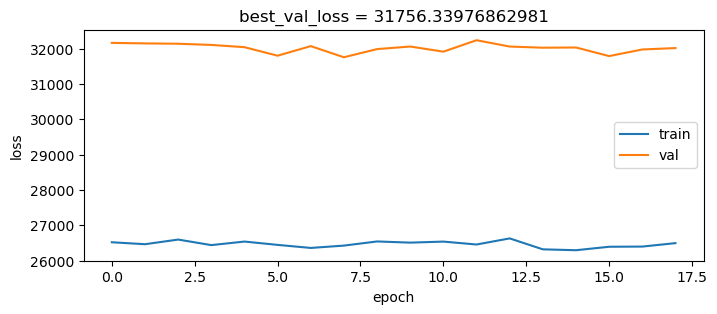

In [24]:
# 再学習
# model = NN(num_in)
# model = model.to(device)

loaded_model = torch.load(save_path)
model.load_state_dict(loaded_model['model_state_dict'])
model = transfer_learning(model, save_path)

num_epoch = 40
early_stopping = 10

opt = optim.Adam(model.parameters(), lr=0.00001, betas=(0.9, 0.999))
# scheduler=None
# opt = optim.SGD(model.parameters(), lr=0.0001)
scheduler = CosineAnnealingLR(opt, T_max=20)
# scheduler = StepLR(opt, step_size=30, gamma=0.1)

train_losses, val_losses, val_accuracies, best_val_loss = utils.learn(model, train_loader, val_loader, opt, nn.MSELoss(), num_epoch=num_epoch, early_stopping=early_stopping, save_path=save_path, scheduler=scheduler, best_val_loss=best_val_loss)

fig = plt.figure(figsize=(8, 3), dpi=100)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'best_val_loss = {best_val_loss}')
# plt.ylim(0, 1000000)
plt.show()

In [26]:
# 検証データの予測

# データ準備
print(f'Read: {val_data}')
with open(val_data, 'rb') as file:
    df = pickle.load(file)
X_val, y_val, _ = Treatment_Data_IMP_FX(df, Features, Target)

# Numpy配列をTensorに変換
X = torch.tensor(X_val.values, dtype=torch.float32)
y = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X = transform(X)

model = NN(num_in)
loaded_model = torch.load(save_path)
model.load_state_dict(loaded_model['model_state_dict'])

y_pred = model(X)

# MSEの計算
# loss = mean_squared_error(y_val.detach().numpy(), y_pred.detach().numpy())
mse = nn.MSELoss()
loss = mse(y, y_pred)
print(f'MSE Loss: {loss}')

X_val[f'{Target}'] = y.detach().numpy()
X_val[f'{Target}_pred'] = y_pred.detach().numpy()
X_val['TIME'] = np.arange(0, len(X_val)*0.005, 0.005)
columns = ['TIME'] + list(X_val.columns)
X_val = X_val[columns]
X_val.to_csv(f'{Target}_{Project}_pred.csv', index=False)

Read: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\val_data_3BVT_EstWhlTrq_FX.pkl
MSE Loss: 31820.21875


### MMotAct

In [22]:
Dir = 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\\'
train_data = f'{Dir}train_data_{Project}.pkl'
val_data = f'{Dir}val_data_{Project}.pkl'

Features = ['MDriverRequest', 'v_RA_kph',	
            'MMotRed', 'MMotRed_10', 'MMotRed_20', 'MMotRed_40', 'MMotRed_100', 'MMotRed_200', 'MMotRed_400',
            'MotPedalPosDriver', 'MotPedalPosDriver_10', 'MotPedalPosDriver_20', 'MotPedalPosDriver_40', 'MotPedalPosDriver_100', 'MotPedalPosDriver_200', 'MotPedalPosDriver_400',
            'MMotAct']

Target = 'MMotAct'

print(f'Read: {train_data}')
with open(train_data, 'rb') as file:
    df = pickle.load(file)
X, y, df = Treatment_Data_MMotAct(df, Features, Target)
df.to_csv(f'train_{Project}_{Target}.csv', index=False)

print(f'Read: {val_data}')
with open(val_data, 'rb') as file:
    df = pickle.load(file)
X_val, y_val, df = Treatment_Data_MMotAct(df, Features, Target)
df.to_csv(f'val_{Project}_{Target}.csv', index=False)

Read: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\train_data_3BVT.pkl
Read: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\val_data_3BVT.pkl


In [20]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = X, X_val, y, y_val

# Numpy配列をTensorに変換
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# データの平均と標準偏差を計算
mean = X_train.mean(dim=0)
std = X_train.std(dim=0)

# Normalize変換を定義
transform = ML.CustomNormalize(mean, std)

train_dataset = ML.MyDataset(X_train, y_train, transform)
val_dataset = ML.MyDataset(X_val, y_val, transform)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=0)

In [21]:
# モデル準備
X, y = next(iter(train_loader))
num_in = X.shape[1]
model = NN(num_in)
model = model.to(device)
model = transfer_learning(model, 'MMotAct_3A0A_model.pth')

In [22]:
# 学習率の最適値
lrs, losses = utils.lr_finder(model, train_loader, nn.MSELoss(), lr_multiplier=1.1)

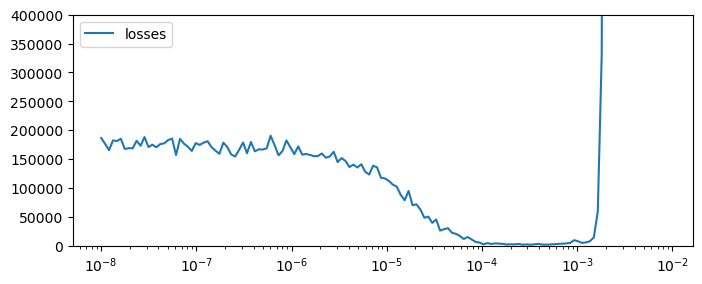

In [23]:
fig = plt.figure(figsize=(8, 3), dpi=100)
plt.plot(lrs, losses, label='losses')
plt.xscale('log')
plt.legend()
plt.ylim(0, 400000)
plt.show()

epoch: 0: train error: 13201.570478074094, validation error: 1376.7481755150689, validation accuracy: 1.9393939393939394


epoch: 1: train error: 2276.1600234660696, validation error: 1152.3560941002586, validation accuracy: 1.9393939393939394


epoch: 2: train error: 2097.4100254140003, validation error: 1035.649807979362, validation accuracy: 1.9393939393939394


epoch: 3: train error: 2041.7541698699301, validation error: 1092.988815143855, validation accuracy: 1.9393939393939394


epoch: 4: train error: 2004.7888391373006, validation error: 1222.2300417062008, validation accuracy: 1.9393939393939394


epoch: 5: train error: 1985.920042322037, validation error: 1014.9039626482761, validation accuracy: 1.9393939393939394


epoch: 6: train error: 1963.1431011443442, validation error: 1374.4922824435764, validation accuracy: 1.9393939393939394


epoch: 7: train error: 1982.3349296082843, validation error: 1142.7625756468435, validation accuracy: 1.9393939393939394


epoch: 8: train error: 1954.131699420036, validation error: 1095.9596980509132, validation accuracy: 1.9393939393939394


epoch: 9: train error: 1953.3535143263796, validation error: 1107.5529409899857, validation accuracy: 1.9393939393939394


epoch: 10: train error: 1938.4791590913812, validation error: 1124.6238754518104, validation accuracy: 1.9393939393939394


epoch: 11: train error: 1934.6055317330868, validation error: 1166.2074567236082, validation accuracy: 1.9393939393939394


epoch: 12: train error: 1955.278444980053, validation error: 1074.7184182369347, validation accuracy: 1.9393939393939394


epoch: 13: train error: 1950.8120883373504, validation error: 1285.007745877661, validation accuracy: 1.9393939393939394


epoch: 14: train error: 1946.727148827086, validation error: 970.720145630114, validation accuracy: 1.9393939393939394


epoch: 15: train error: 1939.3034301108503, validation error: 1173.965911995281, validation accuracy: 1.9393939393939394


epoch: 16: train error: 1884.8143886809653, validation error: 1206.431997852494, validation accuracy: 1.9393939393939394


epoch: 17: train error: 1923.1983442915248, validation error: 1280.7705357014531, validation accuracy: 1.9393939393939394


epoch: 18: train error: 1886.6359171765916, validation error: 1221.298709118005, validation accuracy: 1.9393939393939394


epoch: 19: train error: 1883.8498867927713, validation error: 1137.7984972120535, validation accuracy: 1.9393939393939394


epoch: 20: train error: 1851.6963041589615, validation error: 987.2235662672255, validation accuracy: 1.9393939393939394


epoch: 21: train error: 1864.3806684778092, validation error: 1031.4658403300275, validation accuracy: 1.9393939393939394


epoch: 22: train error: 1820.9669898824488, validation error: 949.1850328782592, validation accuracy: 1.9393939393939394


epoch: 23: train error: 1817.0661526943775, validation error: 1179.0596362460744, validation accuracy: 1.9393939393939394


epoch: 24: train error: 1822.2360128849111, validation error: 901.2789763248328, validation accuracy: 1.9393939393939394


epoch: 25: train error: 1828.791151330826, validation error: 931.6767919810131, validation accuracy: 1.9393939393939394


epoch: 26: train error: 1774.6813641811939, validation error: 955.531507434267, validation accuracy: 1.9393939393939394


epoch: 27: train error: 1813.2283924183946, validation error: 1172.1613726760402, validation accuracy: 1.9393939393939394


epoch: 28: train error: 1772.2557718804542, validation error: 913.5782971478471, validation accuracy: 1.9393939393939394


epoch: 29: train error: 1776.7742280351354, validation error: 916.4698075381192, validation accuracy: 1.9393939393939394


epoch: 30: train error: 1796.1177853523416, validation error: 907.2559162583015, validation accuracy: 1.9393939393939394


epoch: 31: train error: 1775.671283316105, validation error: 1111.6018234154192, validation accuracy: 1.9393939393939394


epoch: 32: train error: 1776.4031109099692, validation error: 1127.4254719994285, validation accuracy: 1.9393939393939394


epoch: 33: train error: 1799.2015390599029, validation error: 955.0229801312842, validation accuracy: 1.9393939393939394


epoch: 34: train error: 1769.475697131867, validation error: 1011.4163592222965, validation accuracy: 1.9393939393939394


epoch: 35: train error: 1798.1379970794028, validation error: 892.4945863232468, validation accuracy: 1.9393939393939394


epoch: 36: train error: 1782.2756302204539, validation error: 1066.898445187193, validation accuracy: 1.9393939393939394


epoch: 37: train error: 1783.713639766612, validation error: 956.3646798952661, validation accuracy: 1.9393939393939394


epoch: 38: train error: 1760.989527925532, validation error: 1013.2678398315353, validation accuracy: 1.9393939393939394


epoch: 39: train error: 1781.027128016695, validation error: 974.6168542341752, validation accuracy: 1.9393939393939394


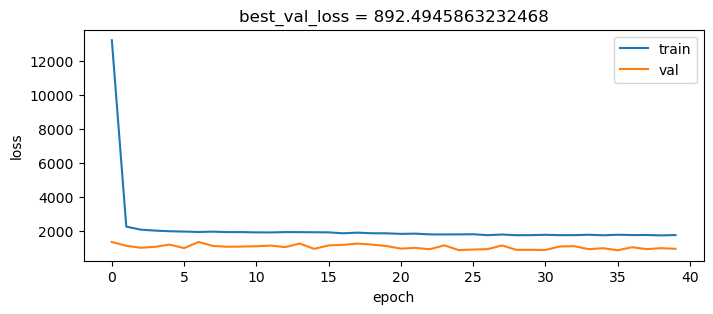

In [24]:
# 学習
model = NN(num_in)
model = model.to(device)
model = transfer_learning(model, 'MMotAct_3A0A_model.pth')

num_epoch = 40
early_stopping = None
save_path = f'MMotAct_{Project}_model.pth'

# opt = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
opt = optim.SGD(model.parameters(), lr=10**-5)
scheduler = CosineAnnealingLR(opt, T_max=10)
# scheduler = StepLR(opt, step_size=20, gamma=0.1)
# scheduler=None

train_losses, val_losses, val_accuracies, best_val_loss = utils.learn(model, train_loader, val_loader, opt, nn.MSELoss(), num_epoch=num_epoch, early_stopping=early_stopping, save_path=save_path, scheduler=scheduler)

fig = plt.figure(figsize=(8, 3), dpi=100)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'best_val_loss = {best_val_loss}')
# plt.ylim(0, 1000000)
plt.show()

epoch: 0: train error: 1760.6407133061834, validation error: 940.168247955014, validation accuracy: 1.9393939393939394


epoch: 1: train error: 1786.8574616452481, validation error: 943.8422971108947, validation accuracy: 1.9393939393939394


epoch: 2: train error: 1777.0756051895466, validation error: 1082.9627967603278, validation accuracy: 1.9393939393939394


epoch: 3: train error: 1746.402189538834, validation error: 1017.8091964962507, validation accuracy: 1.9393939393939394


epoch: 4: train error: 1782.028444006088, validation error: 972.4346876626063, validation accuracy: 1.9393939393939394
Stopping early


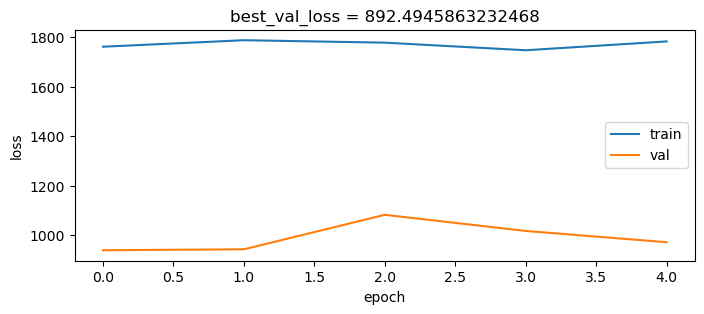

In [25]:
# 再学習
# model = NN(num_in)
# model = model.to(device)

# loaded_model = torch.load(save_path)
# model.load_state_dict(loaded_model['model_state_dict'])
model = transfer_learning(model, save_path)

num_epoch = 100
early_stopping = 5

opt = optim.Adam(model.parameters(), lr=10**-6, betas=(0.9, 0.999))
scheduler=None
# opt = optim.SGD(model.parameters(), lr=0.0001)
# scheduler = CosineAnnealingLR(opt, T_max=20)
# scheduler = StepLR(opt, step_size=30, gamma=0.1)

train_losses, val_losses, val_accuracies, best_val_loss = utils.learn(model, train_loader, val_loader, opt, nn.MSELoss(), num_epoch=num_epoch, early_stopping=early_stopping, save_path=save_path, scheduler=scheduler, best_val_loss=best_val_loss)

fig = plt.figure(figsize=(8, 3), dpi=100)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'best_val_loss = {best_val_loss}')
# plt.ylim(0, 1000000)
plt.show()

In [26]:
# 検証データの予測

# データ準備
print(f'Read: {val_data}')
with open(val_data, 'rb') as file:
    df = pickle.load(file)
X_val, y_val, _ = Treatment_Data_MMotAct(df, Features, Target)

# Numpy配列をTensorに変換
X = torch.tensor(X_val.values, dtype=torch.float32)
y = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X = transform(X)

model = NN(num_in)
loaded_model = torch.load(save_path)
model.load_state_dict(loaded_model['model_state_dict'])

y_pred = model(X)

# MSEの計算
# loss = mean_squared_error(y_val.detach().numpy(), y_pred.detach().numpy())
mse = nn.MSELoss()
loss = mse(y, y_pred)
print(f'MSE Loss: {loss}')

X_val[f'{Target}'] = y.detach().numpy()
X_val[f'{Target}_pred'] = y_pred.detach().numpy()
X_val['TIME'] = np.arange(0, len(X_val)*0.005, 0.005)
columns = ['TIME'] + list(X_val.columns)
X_val = X_val[columns]
X_val.to_csv(f'{Target}_{Project}_pred.csv', index=False)

Read: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\val_data_3BVT.pkl
MSE Loss: 2401.09130859375


### MDriverRequest

In [27]:
Dir = 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\\'
train_data = f'{Dir}train_data_{Project}.pkl'
val_data = f'{Dir}val_data_{Project}.pkl'

Features = ['v_RA_kph', 
            'MotPedalPosDriver', 'MotPedalPosDriver_10', 'MotPedalPosDriver_20', 'MotPedalPosDriver_40', 'MotPedalPosDriver_100', 'MotPedalPosDriver_200', 'MotPedalPosDriver_400',
            'p_MC_Model', 'p_MC_Model_10', 'p_MC_Model_20', 'p_MC_Model_40', 'p_MC_Model_100', 'p_MC_Model_200', 'p_MC_Model_400',
            'nDrvUnit', 'nDrvUnit_10', 'nDrvUnit_20', 'nDrvUnit_40', 'nDrvUnit_100', 'nDrvUnit_200', 'nDrvUnit_400',  
            'MDriverRequest']

Target = 'MDriverRequest'

print(f'Read: {train_data}')
with open(train_data, 'rb') as file:
    df = pickle.load(file)
X, y, df = Treatment_Data_MMotAct(df, Features, Target)
df.to_csv(f'train_{Project}_{Target}.csv', index=False)

print(f'Read: {val_data}')
with open(val_data, 'rb') as file:
    df = pickle.load(file)
X_val, y_val, df = Treatment_Data_MMotAct(df, Features, Target)
df.to_csv(f'val_{Project}_{Target}.csv', index=False)

Read: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\train_data_3BVT.pkl
Read: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\val_data_3BVT.pkl


In [28]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = X, X_val, y, y_val

# Numpy配列をTensorに変換
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# データの平均と標準偏差を計算
mean = X_train.mean(dim=0)
std = X_train.std(dim=0)

# Normalize変換を定義
transform = ML.CustomNormalize(mean, std)

train_dataset = ML.MyDataset(X_train, y_train, transform)
val_dataset = ML.MyDataset(X_val, y_val, transform)

In [29]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=0)

In [30]:
# モデル準備
X, y = next(iter(train_loader))
num_in = X.shape[1]
model = NN(num_in)
model = model.to(device)
model = transfer_learning(model, 'MDriverRequest_3A0A_model.pth')

In [31]:
# 学習率の最適値
lrs, losses = utils.lr_finder(model, train_loader, nn.MSELoss(), lr_multiplier=1.1)

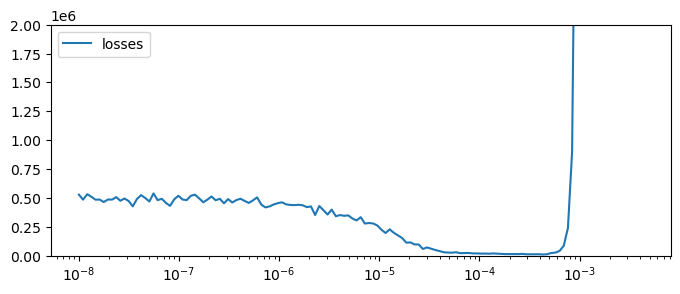

In [32]:
fig = plt.figure(figsize=(8, 3), dpi=100)
plt.plot(lrs, losses, label='losses')
plt.xscale('log')
plt.legend()
plt.ylim(0,2000000)
plt.show()

epoch: 0: train error: 32459.908587516624, validation error: 12566.104341603288, validation accuracy: 0.5656565656565656


epoch: 1: train error: 11283.33293638838, validation error: 10298.389415644637, validation accuracy: 0.5656565656565656


epoch: 2: train error: 10047.233311429936, validation error: 9047.031446900031, validation accuracy: 0.5656565656565656


epoch: 3: train error: 9331.4286343189, validation error: 8340.23174039282, validation accuracy: 0.5656565656565656


epoch: 4: train error: 8845.36996524892, validation error: 7539.722544660472, validation accuracy: 0.5656565656565656


epoch: 5: train error: 8569.610626870013, validation error: 7330.127172412294, validation accuracy: 0.5656565656565656


epoch: 6: train error: 8388.496906686336, validation error: 7359.630360767095, validation accuracy: 0.5656565656565656


epoch: 7: train error: 8277.238822774683, validation error: 7253.572548143791, validation accuracy: 0.5656565656565656


epoch: 8: train error: 8190.030556536735, validation error: 7279.360129423816, validation accuracy: 0.5656565656565656


epoch: 9: train error: 8183.794723186087, validation error: 7382.311398515798, validation accuracy: 0.5656565656565656


epoch: 10: train error: 8206.108989309758, validation error: 7044.476315382755, validation accuracy: 0.5656565656565656


epoch: 11: train error: 8180.333027291806, validation error: 7068.722753158723, validation accuracy: 0.5656565656565656


epoch: 12: train error: 8163.38142297623, validation error: 7167.185828112592, validation accuracy: 0.5656565656565656


epoch: 13: train error: 8115.134187738946, validation error: 7363.378635791817, validation accuracy: 0.5656565656565656


epoch: 14: train error: 8045.827031561669, validation error: 6764.855389797326, validation accuracy: 0.5656565656565656


epoch: 15: train error: 7895.404129352975, validation error: 6643.232509035052, validation accuracy: 0.5656565656565656


epoch: 16: train error: 7705.725461269947, validation error: 6549.635014996384, validation accuracy: 0.5656565656565656


epoch: 17: train error: 7580.6423456719585, validation error: 6141.947698496809, validation accuracy: 0.5656565656565656


epoch: 18: train error: 7375.8160621156085, validation error: 5849.576439703354, validation accuracy: 0.5656565656565656


epoch: 19: train error: 7171.865583703873, validation error: 5702.239119317796, validation accuracy: 0.5656565656565656


epoch: 20: train error: 6996.11632261885, validation error: 5760.954472175752, validation accuracy: 0.5656565656565656


epoch: 21: train error: 6818.366884921459, validation error: 5475.185503950022, validation accuracy: 0.5656565656565656


epoch: 22: train error: 6700.799119015957, validation error: 5223.461468166775, validation accuracy: 0.5656565656565656


epoch: 23: train error: 6586.568694419049, validation error: 5210.021733447759, validation accuracy: 0.5656565656565656


epoch: 24: train error: 6479.311577979554, validation error: 5235.561498507105, validation accuracy: 0.5656565656565656


epoch: 25: train error: 6435.4833218189, validation error: 5124.793706730158, validation accuracy: 0.5656565656565656


epoch: 26: train error: 6402.167586955618, validation error: 5021.846797095404, validation accuracy: 0.5656565656565656


epoch: 27: train error: 6332.265449686253, validation error: 4990.182620318249, validation accuracy: 0.5656565656565656


epoch: 28: train error: 6339.397377825798, validation error: 5029.473546991445, validation accuracy: 0.5656565656565656


epoch: 29: train error: 6299.555562770113, validation error: 4780.857476687191, validation accuracy: 0.5656565656565656


epoch: 30: train error: 6259.196179978391, validation error: 5140.168389696063, validation accuracy: 0.5656565656565656


epoch: 31: train error: 6327.146077906832, validation error: 5136.132611346968, validation accuracy: 0.5656565656565656


epoch: 32: train error: 6296.175729305186, validation error: 5189.523002393318, validation accuracy: 0.5656565656565656


epoch: 33: train error: 6288.875370106799, validation error: 5060.916494802995, validation accuracy: 0.5656565656565656


epoch: 34: train error: 6252.706488426696, validation error: 5004.1914279244165, validation accuracy: 0.5656565656565656


epoch: 35: train error: 6234.859323055186, validation error: 4829.348565650709, validation accuracy: 0.5656565656565656


epoch: 36: train error: 6110.464332093584, validation error: 4834.6657342621775, validation accuracy: 0.5656565656565656


epoch: 37: train error: 6130.398066094581, validation error: 4828.946582245104, validation accuracy: 0.5656565656565656


epoch: 38: train error: 6066.737096908245, validation error: 4725.137920668631, validation accuracy: 0.5656565656565656


epoch: 39: train error: 5928.260772055768, validation error: 4814.845960588166, validation accuracy: 0.5656565656565656


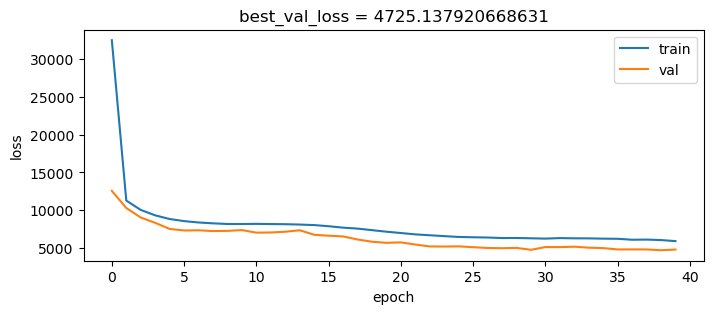

In [33]:
# 学習
model = NN(num_in)
model = model.to(device)
model = transfer_learning(model, 'MDriverRequest_3A0A_model.pth')

num_epoch = 40
early_stopping = None
save_path = f'MDriverRequest_{Project}_model.pth'

opt = optim.SGD(model.parameters(), lr=10**-5)
scheduler = CosineAnnealingLR(opt, T_max=10)
# opt = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
# scheduler = StepLR(opt, step_size=20, gamma=0.1)
# scheduler=None

train_losses, val_losses, val_accuracies, best_val_loss = utils.learn(model, train_loader, val_loader, opt, nn.MSELoss(), num_epoch=num_epoch, early_stopping=early_stopping, save_path=save_path, scheduler=scheduler)

fig = plt.figure(figsize=(8, 3), dpi=100)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'best_val_loss = {best_val_loss}')
# plt.ylim(0, 1000000)
plt.show()

epoch: 0: train error: 5999.044160883477, validation error: 4808.576365788777, validation accuracy: 0.5656565656565656


epoch: 1: train error: 5966.5968835708945, validation error: 4782.3504549662275, validation accuracy: 0.5656565656565656


epoch: 2: train error: 5984.324733003657, validation error: 4880.666006357983, validation accuracy: 0.5656565656565656


epoch: 3: train error: 5960.226193691822, validation error: 4639.3172129814075, validation accuracy: 0.5656565656565656


epoch: 4: train error: 6018.863813684342, validation error: 4748.86309633833, validation accuracy: 0.5656565656565656


epoch: 5: train error: 5968.701414717005, validation error: 4562.048303661924, validation accuracy: 0.5656565656565656


epoch: 6: train error: 6049.896501257064, validation error: 5032.368593312273, validation accuracy: 0.5656565656565656


epoch: 7: train error: 5992.635460386885, validation error: 4642.500868768403, validation accuracy: 0.5656565656565656


epoch: 8: train error: 5943.022111608627, validation error: 4810.598509981175, validation accuracy: 0.5656565656565656


epoch: 9: train error: 5991.841413781998, validation error: 4726.618553431347, validation accuracy: 0.5656565656565656


epoch: 10: train error: 6058.795630921709, validation error: 4804.39984132786, validation accuracy: 0.5656565656565656
Stopping early


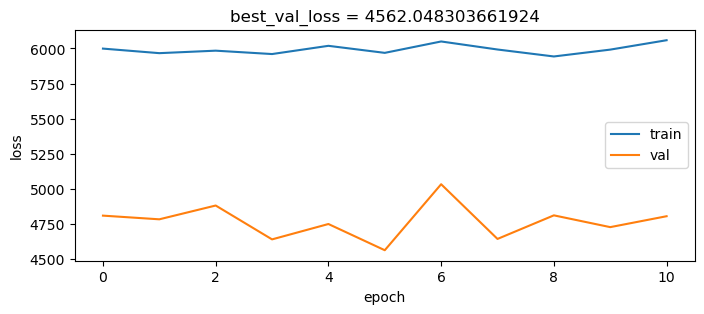

In [34]:
# 再学習
# model = NN(num_in)
# model = model.to(device)

# loaded_model = torch.load(save_path)
# model.load_state_dict(loaded_model['model_state_dict'])
model = transfer_learning(model, save_path)

num_epoch = 100
early_stopping = 5

opt = optim.Adam(model.parameters(), lr=10**-6, betas=(0.9, 0.999))
scheduler=None
# opt = optim.SGD(model.parameters(), lr=0.0001)
# scheduler = CosineAnnealingLR(opt, T_max=20)
# scheduler = StepLR(opt, step_size=30, gamma=0.1)

train_losses, val_losses, val_accuracies, best_val_loss = utils.learn(model, train_loader, val_loader, opt, nn.MSELoss(), num_epoch=num_epoch, early_stopping=early_stopping, save_path=save_path, scheduler=scheduler, best_val_loss=best_val_loss)

fig = plt.figure(figsize=(8, 3), dpi=100)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'best_val_loss = {best_val_loss}')
# plt.ylim(0, 1000000)
plt.show()

In [35]:
# 検証データの予測

# データ準備
print(f'Read: {val_data}')
with open(val_data, 'rb') as file:
    df = pickle.load(file)
X_val, y_val, _ = Treatment_Data_MMotAct(df, Features, Target)

# Numpy配列をTensorに変換
X = torch.tensor(X_val.values, dtype=torch.float32)
y = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X = transform(X)

model = NN(num_in)
loaded_model = torch.load(save_path)
model.load_state_dict(loaded_model['model_state_dict'])

y_pred = model(X)

# MSEの計算
# loss = mean_squared_error(y_val.detach().numpy(), y_pred.detach().numpy())
mse = nn.MSELoss()
loss = mse(y, y_pred)
print(f'MSE Loss: {loss}')

X_val[f'{Target}'] = y.detach().numpy()
X_val[f'{Target}_pred'] = y_pred.detach().numpy()
X_val['TIME'] = np.arange(0, len(X_val)*0.005, 0.005)
columns = ['TIME'] + list(X_val.columns)
X_val = X_val[columns]
X_val.to_csv(f'{Target}_{Project}_pred.csv', index=False)

Read: c:\TSDE_Workarea\ktt2yk\CARSIM\Sim_Work_HGT_3BVT_BB88574_VAR01_Matlab2012b\val_data_3BVT.pkl
MSE Loss: 11552.49609375
